# Sales forecasting system (Regression Problem)

## Time series prediction in Python

In [15]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import joblib

**STEP 1: PROBLEM STATEMENT & DATA COLLECTION**

***1.1 PROBLEM STATEMENT***

**Goal-** to develop a sales forecasting system to estimate the sales growth rate for the upcoming months. This information will help determine the necessary storage space required for a new warehouse as the company prepares to expand its operations.

#### This project will be developed in order to answer the following questions:
* Which is the tensor of the time serie?
* Which is the trend?
* Is it stationary?
* Is there variability or noise?

***1.2 DATA COLLECTION***

In [30]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [31]:
df.to_csv("../data/raw/sales.csv", index=False)

In [33]:
# Obtaining Dataset dimensions:
print("Dataset dimensions:")
print(df.shape)

Dataset dimensions:
(366, 2)


In [34]:
# Obtaining Dataset informations:
print("Dataset informations:")
print(df.info())

Dataset informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [35]:
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


**1.3 DATA TRANSFORMATION**

In [36]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
print(df.head())


                                sales
date                                 
2022-09-03 17:10:08.079328  55.292157
2022-09-04 17:10:08.079328  53.803211
2022-09-05 17:10:08.079328  58.141693
2022-09-06 17:10:08.079328  64.530899
2022-09-07 17:10:08.079328  66.013633


In [37]:
ts = df['sales']
ts.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

**1.4 TIME SERIES VISUALIZATION**

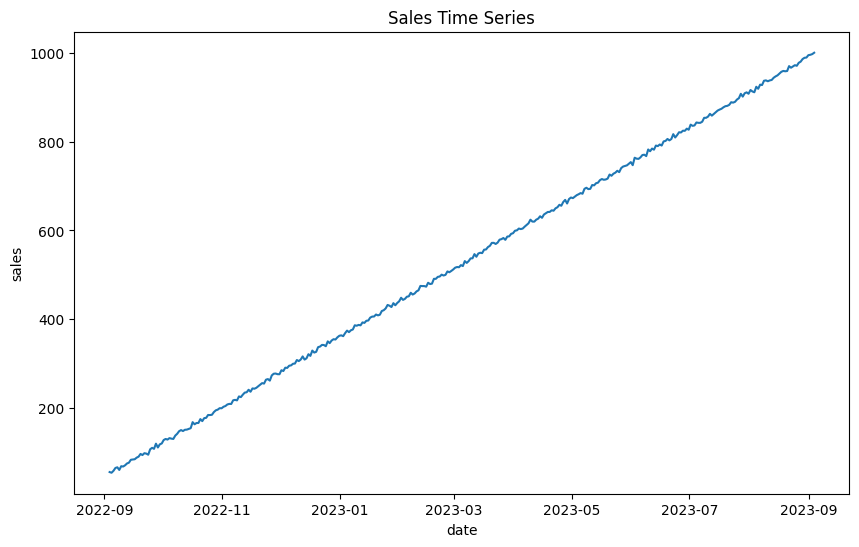

In [42]:
fig, axis = plt.subplots(figsize = (10, 6))
sns.lineplot(data=ts)
plt.title("Sales Time Series")
plt.show()


**STEP 2: BUILDING AND ANALYZING THE TIME SERIES**

***Which is the tensor of the time serie?***

In [60]:
freq_ = pd.infer_freq(ts.index)
print("Inferred frequency:", freq_)


Inferred frequency: D


#### Statement:
* the data has a daily granularity (D = daily)

***QUESTION 2: Which is the trend? (trend)***

#### 2.1 Decomposition of the series

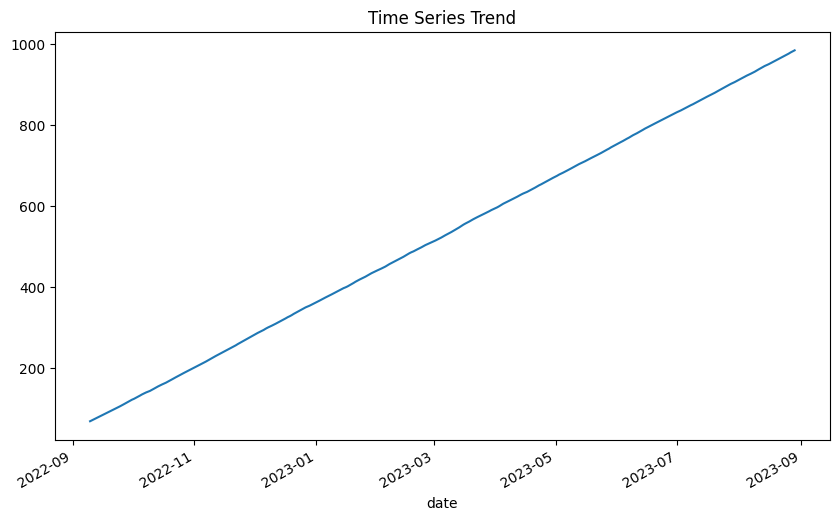

In [43]:
decomposition = seasonal_decompose(ts, period=12)
decomposition.trend.plot(figsize=(10, 6), title="Time Series Trend")
plt.show()


#### 2.2 Trend analysis

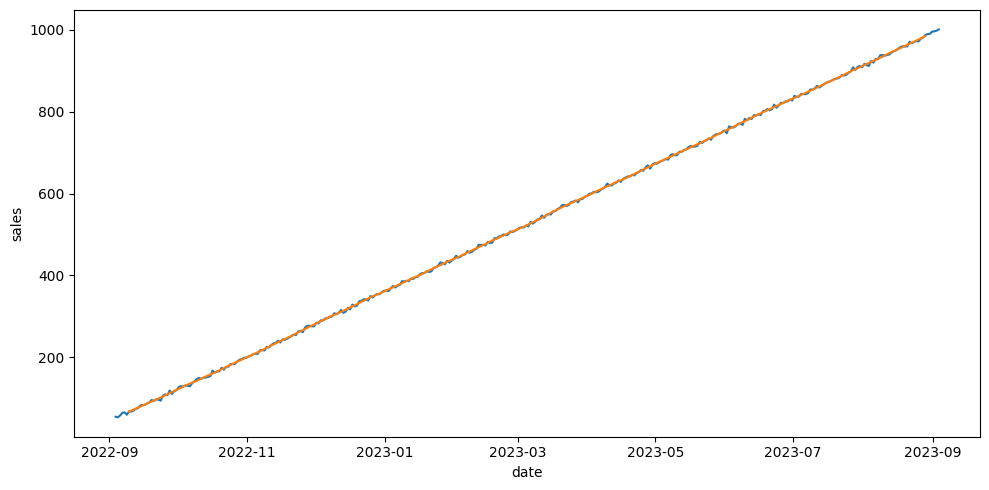

In [46]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

#### Statement: 
* this confirms a clear positive trend over the years.

***QUESTION 3: Is it stationary? (seasonality)***

In [49]:
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)


Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

#### Statement:
* p-value is greater than 0.05, which means that null hypothesis will be rejected, and I will take this series as non-stationary.

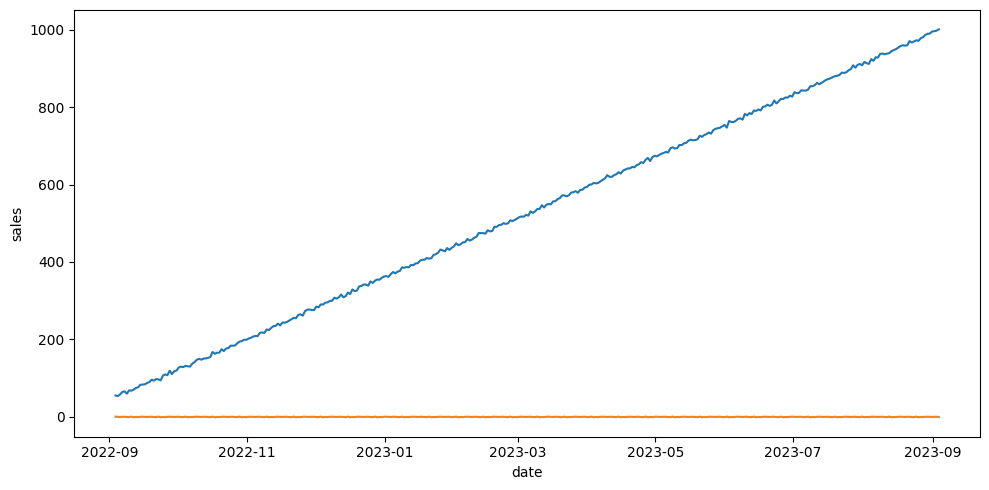

In [47]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

#### Statement:
* This graph confirms that the time series is not stationary, since it presents temporal dependencies, such as trends and seasonality, which need to be addressed before training a model such as ARIMA.

***QUESTION 4: Is there variability or noise? (variability)***

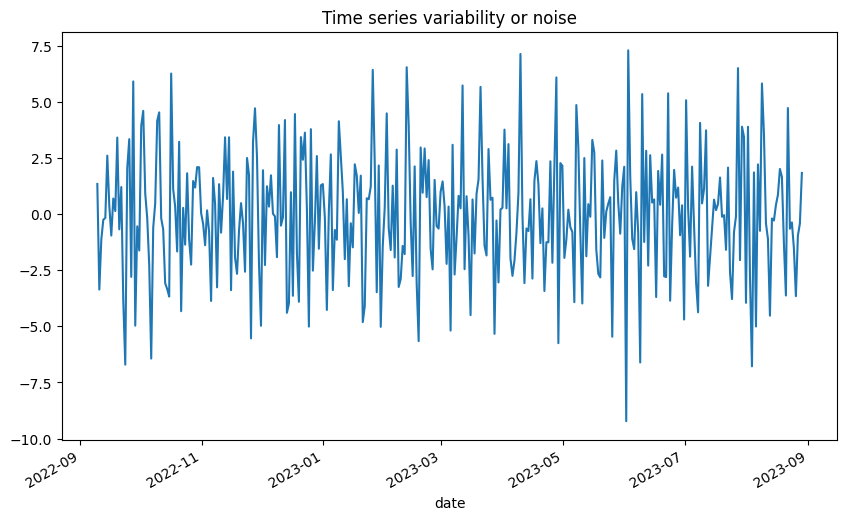

In [51]:
decomposition.resid.plot(figsize=(10, 6), title="Time series variability or noise")
plt.show()

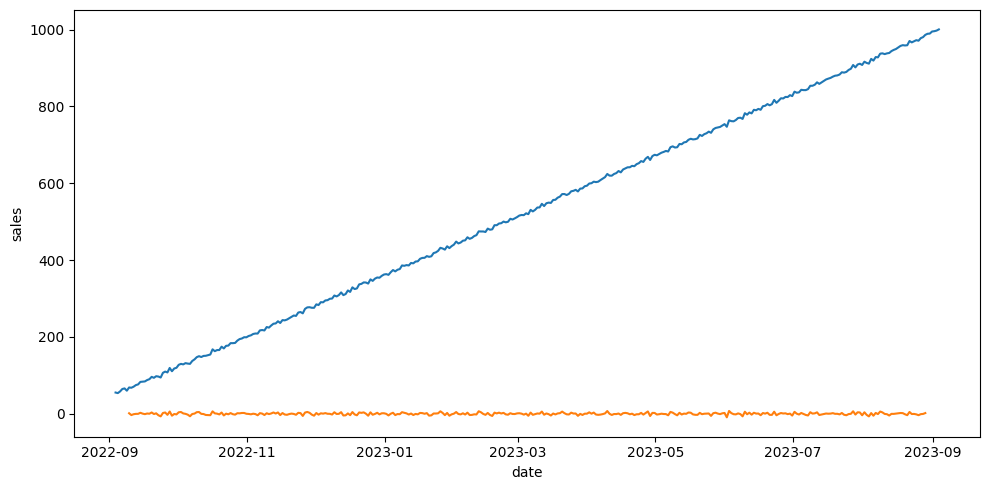

In [52]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

#### Statement:
* This partially confirms the observed behavior, as the residual variability appears to be more pronounced at both the beginning and the end of the studied period.

**AUTOCORRELATION ANALYSIS**

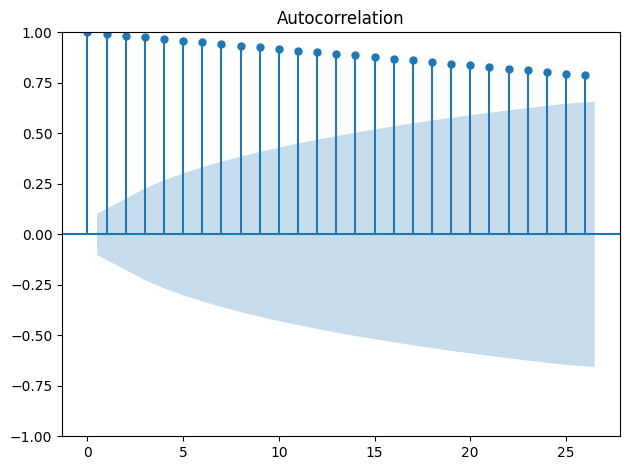

In [54]:
plot_acf(ts)

plt.tight_layout()

plt.show()

#### Statement: 
* there is a significant temporal dependence in the data.

**STEP 3: MODEL TRAINING with an ARIMA model**

In [67]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)


Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

#### Statements: 
* p-values significantly lower than 0.05 - the series is stationary.
* At this point, time-dependent patterns (such as trends) have been removed, and the series is ready to be used in training an ARIMA model.

In [ ]:
train = ts[:int(0.8 * len(df))]
test = ts[int(0.8 * len(df)):]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(p, d, q))  # Substituir p, d, q pelos valores ajustados
arima_result = arima_model.fit()
print(arima_result.summary())


In [ ]:
forecast = arima_result.forecast(steps=len(test))
plt.figure(figsize=(10, 6))
plt.plot(test, label='Valores Reais')
plt.plot(forecast, label='Previsões', color='green')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(test, forecast, squared=False)
mae = mean_absolute_error(test, forecast)
print("RMSE:", rmse)
print("MAE:", mae)


In [ ]:
import joblib

joblib.dump(arima_result, 'arima_model.pkl')


In [ ]:
#loaded_model = joblib.load('arima_model.pkl')
